In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from scipy.fftpack import fft
from torch.autograd import Variable
from sklearn.metrics import precision_score
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Data processing

In [2]:
legal_labels = 'yes no up down left right on off stop go silence unknown'.split()
train_data_path = Path('./train/audio')
valid_subset_path = Path('./train/validation_list.txt')

In [3]:
def unzip2(values):
    a, b = zip(*values)
    return list(a), list(b)

In [4]:
class SoundDataset(Dataset):
    def __init__(self, directory, subset_path=None, transform=None):
        self.directory = directory
        self.transform = transform
        self._subset = self._load_subset(subset_path) if subset_path else None
        self._labels, self._sounds = self._list_of_wavs(directory)
        self._transformed_labels = self._transform_labels(self._labels)
    
    def __len__(self):
        return len(self._labels)
    
    def __getitem__(self, idx):
        label, sound = self._labels[idx], self._sounds[idx]
        sample_rate, samples = wavfile.read(self.directory/label/sound)
        label = self._transformed_labels[idx]
        sample = {'sample_rate': sample_rate, 'samples': samples, 'label': label}
        
        if self.transform is not None:
            sample = self.transform(sample)
            
        return sample
    
    def _is_needed(self, name):
        return (name in self._subset) if self._subset is not None else True
    
    def _list_of_wavs(self, directory, ext='wav'):
        return unzip2(path.parts[-2:] for path in directory.glob(f'*/*.{ext}') if self._is_needed(path.parts[-1]))
    
    @staticmethod
    def _load_subset(file):
        return set(path.split('/')[1] for path in file.read_text().split('\n'))
    
    @staticmethod
    def _transform_labels(labels):
        nlabels = []

        for label in labels:
            if label == '_background_noise_':
                nlabels.append('silence')
            elif label not in legal_labels:
                nlabels.append('unknown')
            else:
                nlabels.append(label)

        return np.array(pd.get_dummies(pd.Series(nlabels)), dtype=np.float32)

In [5]:
class RandomChop:
    def __init__(self, length=16_000):
        self.length = length
    
    def __call__(self, sample):
        sample_rate, samples, label = sample['sample_rate'], sample['samples'], sample['label']
        samples = self._pad_audio(samples)
        
        if len(samples) > self.length:
            samples = self._chop_audio(samples)
        
        return {'sample_rate': sample_rate, 'samples': samples, 'label': label}
            
    def _pad_audio(self, samples):
        if len(samples) >= self.length: 
            return samples

        return np.pad(samples, pad_width=(self.length - len(samples), 0), mode='constant', constant_values=(0, 0))

    def _chop_audio(self, samples):
        start = np.random.randint(0, len(samples) - self.length)
        return samples[start : start + self.length]

In [6]:
class Specgram:
    def __init__(self, sample_rate=8_000):
        self.sample_rate = sample_rate
        
    def __call__(self, sample):
        sample_rate, samples, label = sample['sample_rate'], sample['samples'], sample['label']
        resampled = signal.resample(samples, int(self.sample_rate / sample_rate * samples.shape[0]))
        _, _, specgram = self._log_specgram(resampled, sample_rate=self.sample_rate)
        specgram = specgram.reshape(1, specgram.shape[0], specgram.shape[1])
        return {'samples': specgram, 'label': label}
        
    @staticmethod
    def _log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
        nperseg = int(round(window_size * sample_rate / 1e3))
        noverlap = int(round(step_size * sample_rate / 1e3))
        freqs, times, spec = signal.spectrogram(audio,
                                                fs=sample_rate,
                                                window='hann',
                                                nperseg=nperseg,
                                                noverlap=noverlap,
                                                detrend=False)

        return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [7]:
class ToTensor:
    def __call__(self, sample):
        samples, label = sample['samples'], sample['label']
        return {'samples': torch.from_numpy(samples), 'label': torch.from_numpy(label)}

In [8]:
data_transform = transforms.Compose([RandomChop(), Specgram(), ToTensor()])
train_dataset = SoundDataset(train_data_path, transform=data_transform)
valid_dataset = SoundDataset(train_data_path, valid_subset_path, transform=data_transform)

In [9]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True, num_workers=4)

# Model

In [10]:
dropout = nn.Dropout(p=0.30)


class ConvRes(nn.Module):
    def __init__(self, insize, outsize):
        super(ConvRes, self).__init__()
        
        self.math = nn.Sequential(
            nn.BatchNorm2d(insize),
            torch.nn.Conv2d(insize, outsize, kernel_size=2, padding=2),
            nn.PReLU(),
        )

    def forward(self, x):
        return self.math(x)


class ConvCNN(nn.Module):
    def __init__(self, insize, outsize, kernel_size=7, padding=2, pool=2, avg=True):
        super(ConvCNN, self).__init__()
        self.avg = avg
        self.math = torch.nn.Sequential(
            torch.nn.Conv2d(insize, outsize, kernel_size=kernel_size, padding=padding),
            torch.nn.BatchNorm2d(outsize),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(pool, pool),
        )
        self.avgpool = torch.nn.AvgPool2d(pool, pool)

    def forward(self, x):
        x = self.math(x)
        
        if self.avg is True:
            x = self.avgpool(x)
            
        return x


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
 
        self.avgpool = nn.AdaptiveAvgPool2d(1)

        self.cnn1 = ConvCNN(1, 32, kernel_size=7, pool=4, avg=False)
        self.cnn2 = ConvCNN(32, 32, kernel_size=5, pool=2, avg=True)
        self.cnn3 = ConvCNN(32, 32, kernel_size=5, pool=2, avg=True)

        self.res1 = ConvRes(32, 64)

        self.features = nn.Sequential(
            self.cnn1, 
            dropout,
            self.cnn2,
            self.cnn3,
            self.res1,
        )

        self.classifier = torch.nn.Sequential(
            nn.Linear(1024, 12),
        )
        self.sig = nn.Sigmoid()
  
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Testing

In [11]:
LR = 0.005
MOMENTUM = 0.9

model = Net()
loss_func = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=5e-5) #  L2 regularization

In [12]:
def train(epoch, dataloader, log_steps=250):
    n_total = dataloader.batch_size * len(dataloader)
    last_batch = len(dataloader)
    
    loss_history = []
    loss_batch_history = []

    model.train()
    
    for batch_idx, batch in enumerate(dataloader, 1):
        data, target = Variable(batch['samples']), Variable(batch['label'])
                 
        optimizer.zero_grad()
        preds = model(data)
        loss = loss_func(preds, target)
        loss.backward()
        optimizer.step()
        
        loss_batch_history.append(loss.data[0])
            
        if batch_idx % log_steps == 0 or batch_idx == last_batch:
            loss_history.append(np.mean(loss_batch_history))
            loss_batch_history = []
            
            n_samples = min(batch_idx * dataloader.batch_size, n_total)
            progress = 100. * n_samples / n_total
            print(f'Train Epoch: {epoch} [{n_samples}/{n_total} ({progress:.0f}%)]\tLoss: {loss.data[0]:.6f}')
    
    return loss_history

Epoch 1
Train Epoch: 1 [8000/64736 (12%)]	Loss: 0.118003
Train Epoch: 1 [16000/64736 (25%)]	Loss: 0.097058
Train Epoch: 1 [24000/64736 (37%)]	Loss: 0.084505
Train Epoch: 1 [32000/64736 (49%)]	Loss: 0.044929
Train Epoch: 1 [40000/64736 (62%)]	Loss: 0.086806
Train Epoch: 1 [48000/64736 (74%)]	Loss: 0.030243
Train Epoch: 1 [56000/64736 (87%)]	Loss: 0.105790
Train Epoch: 1 [64000/64736 (99%)]	Loss: 0.046144
Train Epoch: 1 [64736/64736 (100%)]	Loss: 0.073868
Epoch 2
Train Epoch: 2 [8000/64736 (12%)]	Loss: 0.049021
Train Epoch: 2 [16000/64736 (25%)]	Loss: 0.085625
Train Epoch: 2 [24000/64736 (37%)]	Loss: 0.036965
Train Epoch: 2 [32000/64736 (49%)]	Loss: 0.041786
Train Epoch: 2 [40000/64736 (62%)]	Loss: 0.035610
Train Epoch: 2 [48000/64736 (74%)]	Loss: 0.061512
Train Epoch: 2 [56000/64736 (87%)]	Loss: 0.049652
Train Epoch: 2 [64000/64736 (99%)]	Loss: 0.074203
Train Epoch: 2 [64736/64736 (100%)]	Loss: 0.036081
Epoch 3
Train Epoch: 3 [8000/64736 (12%)]	Loss: 0.074172
Train Epoch: 3 [16000/64736

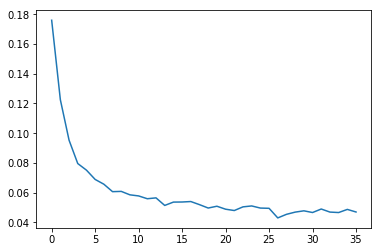

In [13]:
%%time

loss_history = []

for epoch in range(1, 5):
    print("Epoch %d" % epoch)
    loss_history += train(epoch, train_dataloader)
    
plt.plot(loss_history);

In [19]:
def evaluate(dataloader):
    y_true = np.zeros(0)
    y_pred = np.zeros(0)
    
    for batch_idx, batch in enumerate(dataloader, 1):
        data, target = Variable(batch['samples']), batch['label'].numpy()     
        y_true = np.concatenate((y_true, np.argmax(target, axis=1)))
        y_pred = np.concatenate((y_pred, np.argmax(model(data).data.numpy(), axis=1)))
    
    return y_true, y_pred

In [20]:
y_true, y_pred = evaluate(valid_dataloader)

In [28]:
precision = precision_score(y_true, y_pred, average='macro')
print(f'Precision: {precision: 0.3f}')

Precision:  0.520
